In [1]:
%matplotlib inline
import os
import time
import numpy as np
from matplotlib import pyplot as plt

from caen_felib import lib, device, error

# Get CAEN FELib path
print(f'CAEN FELib found at: {lib.path} (version={lib.version})')

CAEN FELib found at: libCAEN_FELib.so (version=1.3.1)


In [2]:
from lgdo import lh5, Table, Array, WaveformTable, ArrayOfEqualSizedArrays

## Connect

In [3]:
#dig = device.connect("dig2://192.168.0.254")
dig = device.connect("dig2://caendgtz-usb-52696")
print(f'Connected to digitizer (handle={hex(dig.handle)}, name={dig.name})')

Connected to digitizer (handle=0xcae0000000000000, name=)


In [4]:
tree = dig.get_device_tree()

In [ ]:
#for par in tree["ch"]["0"]["par"]:
for par, par_dict in tree["par"].items():
    if isinstance(par_dict, dict) and "accessmode" in par_dict:
        if par_dict['accessmode']['value'] == "READ_ONLY":#"READ_WRITE":
            alv = []
            if 'allowedvalues' in par_dict:
                allowedvalues = par_dict['allowedvalues']
                for a in allowedvalues:
                    if isinstance(allowedvalues[a], dict):
                        alv.append(allowedvalues[a]["value"])
            def_val = ""
            if 'defaultvalue' in par_dict:
                def_val = par_dict['defaultvalue']['value']
            print(f"  {par}: {def_val} # ({par_dict['datatype']['value']}) [{alv}] {par_dict['description']['value']}")

In [ ]:
# Reset
dig.cmd.Reset()

fw_type = dig.par.fwtype.value
fw_ver = dig.par.fpga_fwver.value
print(fw_type, fw_ver)

adc_samplrate_msps = float(dig.par.adc_samplrate.value)  # in Msps
adc_n_bits = int(dig.par.adc_nbit.value)
sampling_period_ns = int(1e3 / adc_samplrate_msps)

print(f"Sampling rate = {adc_samplrate_msps} MHz, n. bit = {adc_n_bits}, Sampling period = {sampling_period_ns} ns")

# Configuration parameters
nch = int(dig.par.NumCh.value)
active_ch = 1
#reclen = 4084 #sample
reclen = 125000 #sample
pretrg = 2042 #sample
dc_offset = 10

dig.par.iolevel.value = "TTL"
dig.par.recordlengths.value = f"{reclen}"
dig.par.pretriggers.value = f"{pretrg}"

#dig.par.acqtriggersource.value = "TrgIn"
dig.par.acqtriggersource.value = "SwTrg"

# Set some channel parameters
for i, ch in enumerate(dig.ch):
    ch.par.chenable.value = "TRUE" if i < active_ch else "FALSE"  # Enable only channel 0
    ch.par.dcoffset.value = f"{dc_offset}"
    if i < active_ch:
        print(ch.par["dcoffset"].value)

In [ ]:
ch.set_value("

## Configure endpoint

In [ ]:
data_format = [
    {
        'name': 'EVENT_SIZE',
        'type': 'SIZE_T',
    },
    {
        'name': 'TIMESTAMP',
        'type': 'U64',
    },
    {
        'name': 'WAVEFORM',
        'type': 'U16',
        'dim': 2,
        'shape': [active_ch, reclen],
    },
    {
        'name': 'WAVEFORM_SIZE',
        'type': 'U64',
        'dim': 1,
        'shape': [active_ch],
    },
]

In [ ]:
decoded_endpoint_path = "scope"
endpoint = dig.endpoint[decoded_endpoint_path]
data = endpoint.set_read_data_format(data_format)
dig.endpoint.par.ACTIVEENDPOINT.value = decoded_endpoint_path

event_size = data[0].value
timestamp = data[1].value
waveform = data[2].value
waveform_size = data[3].value

In [ ]:
nev = 10
timestamps = np.zeros((active_ch,nev),dtype=np.uint64)
wfs = np.zeros((active_ch,nev,reclen),dtype=np.uint16)
temp_names = ["tempsensfirstadc","tempsenshottestadc","tempsenslastadc","tempsensairin","tempsensairout","tempsenscore","tempsensdcdc"]
temperatures = np.zeros((nev,len(temp_names)),dtype=float)

In [ ]:
dig.cmd.armacquisition()
dig.cmd.swstartacquisition()
for i in range(nev):
    time.sleep(1/1000)
    dig.cmd.sendswtrigger() # to send software trigger
    try:
        endpoint.read_data(-1, data)
    except error.Error as ex:
        if ex.code == error.ErrorCode.TIMEOUT:
            continue
        if ex.code == error.ErrorCode.STOP:
            break
        else:
            raise ex
    for j in range(active_ch):
        wfs[j,i] = waveform[j]
        timestamps[j,i] = timestamp
        for k, temp in enumerate(temp_names):
            temp_value = float(dig.get_value(f"/par/{temp}"))
            temperatures[i][k] = temp_value
dig.cmd.disarmacquisition()

# read files

In [11]:
from datetime import datetime

In [4]:
raw_data = lh5.read("ch000/raw","../tmp/test_20250530T165106Z.lh5")

In [5]:
wfs = raw_data.waveform.values.nda
timestamp = raw_data.timestamp.nda

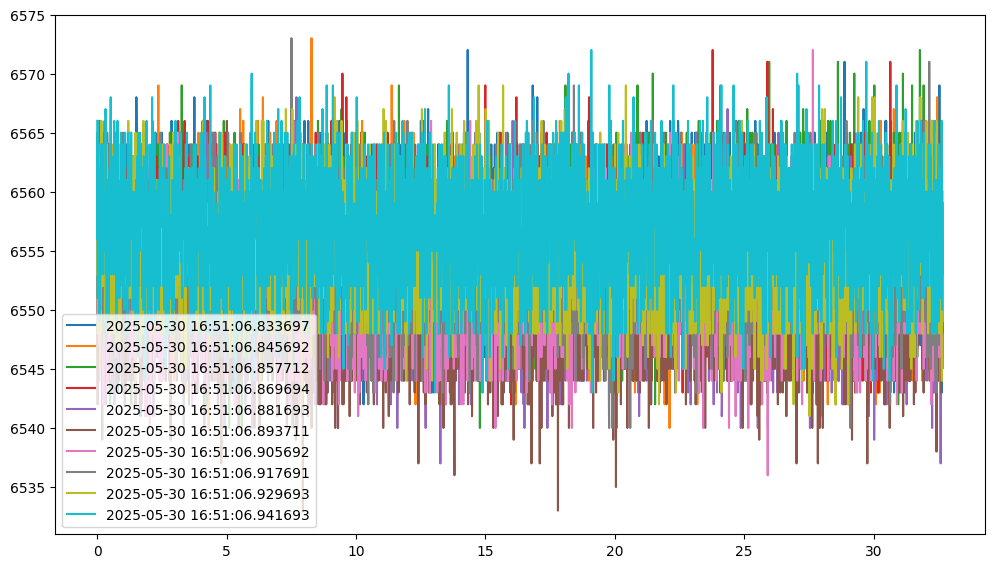

In [13]:
dts = np.linspace(0,4084*0.008,4084)
fig, ax = plt.subplots(figsize=(12,6.75))
for i in range(10):
    wf0 = wfs[i]# - np.mean(wfs[0,i,:100])
    date = datetime.fromtimestamp(timestamp[i]/1e9)
    plt.plot(dts,wf0,label=date)
    #label=f"T = {temperatures[i,3]}°C (1st), {temperatures[i,4]}°C (last)")
#plt.xlim(15,20)
#plt.ylim(15000,25000)
ax.legend()

In [ ]:
from scipy.signal import periodogram

In [ ]:
nev, wsize = wfs0.shape
sampling_rate =  1 / 8 * 1e9 # rate in Hz
for j in range(nev):
    (freq, psd_tmp) = periodogram(wfs0[j], sampling_rate, scaling='density')
    if j == 0: psd = psd_tmp
    else: psd += psd_tmp
psd = np.array(psd / nev)
psd_db = 10 * np.log10(psd)
freq = np.array(freq)
rms_total = np.sqrt(np.trapz(psd, freq))

In [ ]:
plt.plot(freq[1:]/1e6, psd[1:], label=f"RMS = {rms_total:.2f} LSB")
plt.ylabel(r"Power Spectral Density ([ADC$^2$/Hz])")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (MHz)")

# Reading raw files

In [ ]:
raw_file = "/mnt/c/Users/valda/data/test_pulser_buffers/20241128_hc_buffer/pulser_pb5_400mV_100Hz_initest_000.lh5"
dig_data = lh5.read("dig/raw",raw_file)
temp0 = dig_data.temp0.nda
raw_data0 = lh5.read("ch000/raw",raw_file)
raw_data1 = lh5.read("ch001/raw",raw_file)
#raw_data2 = lh5.read("ch002/raw",raw_file)
#raw_data3 = lh5.read("ch003/raw",raw_file)
#raw_data4 = lh5.read("ch004/raw",raw_file)
timestamp = raw_data0.timestamp.nda
wfs0 = raw_data0.waveform.values.nda
wfs1 = raw_data1.waveform.values.nda
#wfs2 = raw_data2.waveform.values.nda
#wfs3 = raw_data3.waveform.values.nda
#wfs4 = raw_data4.waveform.values.nda

In [ ]:
dts = np.linspace(0,0.008*len(wf0),len(wf0))

In [ ]:
for i in range(1):
    fig, ax = plt.subplots(figsize=(8,4.5))
    ts = timestamp[i] - timestamp[0]
    wf0 = wfs0[i]# - np.mean(wfs[i,:1000])
    wf1 = wfs1[i]# - np.mean(wfs1[i,:1000])
    #wf2 = wfs2[i]# - np.mean(wfs1[i,:1000])
    #wf3 = wfs3[i]# - np.mean(wfs1[i,:1000])
    #wf4 = wfs4[i]# - np.mean(wfs1[i,:1000])
    ax.plot(dts,wf0,label="output 0")
    ax.plot(dts,wf1+1000,label="output 1")
    #ax.plot(dts,wf2+2000,label="output 2")
    #ax.plot(dts,wf3+3000,label="output 3")
    #ax.plot(dts,wf4+4000,label="output 4")
    ax.set_xlim(16.8,17.8)
    ax.legend(title=f"time={ts}, T = {temp0[i]} °C")
    ax.set_xlabel("Time ($\mu$s)")

In [ ]:
fig, ax = plt.subplots(figsize=(12,6.75))
#ax.plot(voltages,wf_max,"b.")
pars = np.polyfit(voltages,wf_max,1)
ax.plot(wf_max,wf_max-np.polyval(pars,voltages),"b.")
ax.axhline(0,color="k",ls=":")
ax.set_ylabel("Residuals (LSB)")
ax.set_xlabel("ADC channels (LSB)")